In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset


In [3]:
# load datasets
books = pd.read_csv('/content/drive/MyDrive/colab_notebooks/data/Books.csv')
ratings = pd.read_csv('/content/drive/MyDrive/colab_notebooks/data/Ratings.csv')
users = pd.read_csv('/content/drive/MyDrive/colab_notebooks/data/Users.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [36]:
print(books.shape)
books.rename(columns = {'ISBN':'isbn', 'Book-Title':'book_title'}, inplace=True)

print(books.info())

(271360, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   isbn                 271360 non-null  object
 1   book_title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB
None


In [5]:
print(ratings.shape)
ratings.columns = ['user_id','isbn','rating']

print(ratings.info())

(1149780, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   user_id  1149780 non-null  int64 
 1   isbn     1149780 non-null  object
 2   rating   1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB
None


In [6]:
print(users.shape)
users.columns = ['user_id','location', 'age']
print(users.info())

(278858, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user_id   278858 non-null  int64  
 1   location  278858 non-null  object 
 2   age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB
None


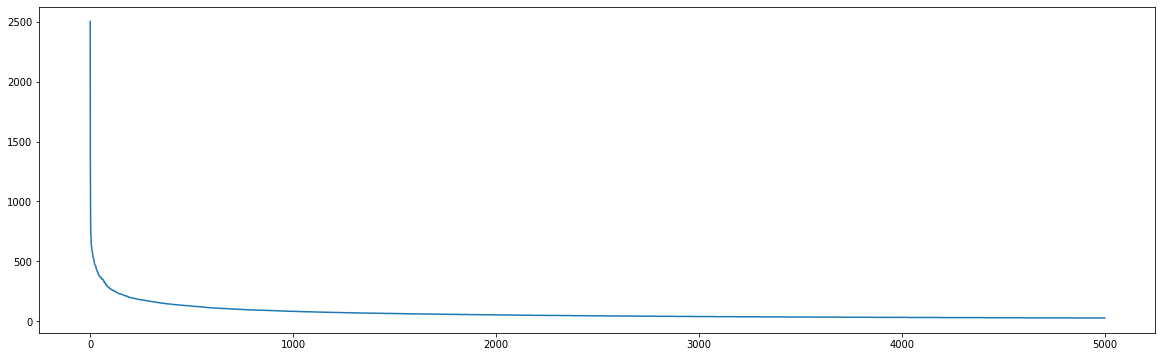

In [7]:
num_book_ratings = ratings.isbn.value_counts().values

plt.figure(figsize=(20,6))
plt.plot(np.arange(0,5000), num_book_ratings[:5000])

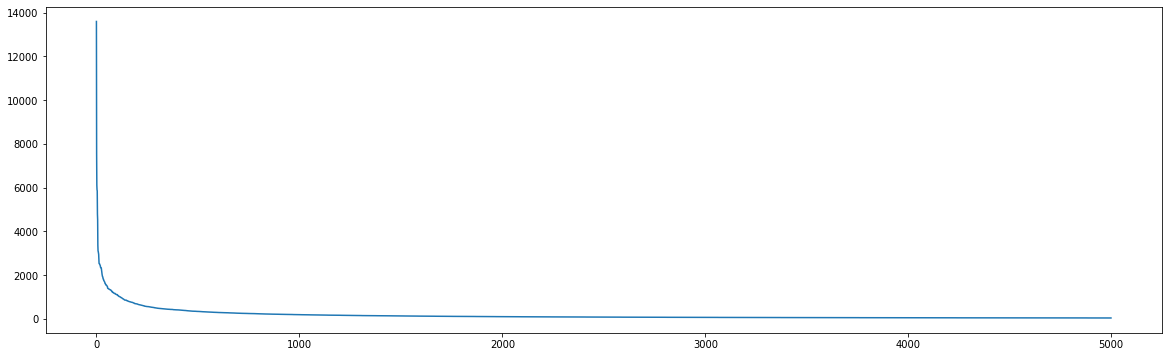

In [8]:
num_ratings = ratings.user_id.value_counts().values

plt.figure(figsize=(20,6))
plt.plot(np.arange(0,5000), num_ratings[:5000])

In [9]:
import recmetrics

## Problem

* Give top N book recommendations to a particular user. 

We assess the quality of the recommendations 

## Model 1 - Collaborative filtering with filtered data as features.

Following [this](https://www.analyticsvidhya.com/blog/2021/06/build-book-recommendation-system-unsupervised-learning-project/) guide, we start by training a nearest neighbor model with a sparse matrix of user-book ratings. 

In [10]:
print("Number of unique user_id in ratings table: ", ratings.user_id.nunique())
print("Number of users with more than 5 ratings: ",(ratings.user_id.value_counts() >= 5).sum())
print("Number of users with more than 10 ratings: ",(ratings.user_id.value_counts() >= 10).sum())
print("Number of users with more than 20 ratings: ",(ratings.user_id.value_counts() >= 20).sum())

Number of unique user_id in ratings table:  105283
Number of users with more than 5 ratings:  22816
Number of users with more than 10 ratings:  13097
Number of users with more than 20 ratings:  7369


In [11]:
print("Number of unique isbn in ratings table: ", ratings.isbn.nunique())
print("Number of books with more than 5 ratings: ",(ratings.isbn.value_counts() >= 5).sum())
print("Number of books with more than 10 ratings: ",(ratings.isbn.value_counts() >= 10).sum())
print("Number of books with more than 20 ratings: ",(ratings.isbn.value_counts() >= 20).sum())

Number of unique isbn in ratings table:  340556
Number of books with more than 5 ratings:  43765
Number of books with more than 10 ratings:  18319
Number of books with more than 20 ratings:  7490


In [32]:
movie_filter = pd.DataFrame(ratings.isbn.value_counts())
movie_filter = movie_filter[movie_filter.isbn >= 20].index
ratings_filtered = ratings[ratings.isbn.isin(movie_filter)].reset_index(drop=True)

In [38]:
ratings_filtered = ratings_filtered.merge(books[['isbn','book_title']], on='isbn', how='left')

In [39]:
ratings_mtx = ratings_filtered.pivot_table(index='user_id', columns='book_title', values='rating')

In [ ]:
from scipy.sparse import csr_matrix
ratings_mtx_sparse = csr_matrix(ratings_mtx)

In [ ]:
from sklearn.neighbors import NearestNeighbors
mdl = NearestNeighbors(algorithm='brute')
mdl.fit(book_sparse)